In [2]:
import path
import libs.checker as checker
import libs.dReal as dReal
from control import *
from z3 import *
from scipy.signal import lti, step
import scipy.signal as sig
from matplotlib import pyplot as p

This example is borrowed and adapted from [1], which aims to control the bank of an airplane by using a aileron actuator, the design needs to satisfy a time-domain requirment: no overshoot.

Using our symbolic static checking, the design is found that doesn't met the safety requirement. In this case, our checker return *sat* and a counter example.

[1] Richard C.. Dorf, and Robert H. Bishop. Modern control systems. Pearson Prentice Hall, 2016. Section 5.9. 

The original closed-loop transfer function is given by *Hs*, which can be represented by a 3-order transfer function:
$$
H(s) = \frac{114 K}{s^3 + 11.4 s^2 + 14 s + 114 K}
$$

The approximated transfer function can be obtained by using a *same frequency response method*:
$$
\hat{H}(s) = \frac{11.29 K}{s^2+\sqrt{1.92-2.91K} + 11.29K}
$$

The question is that: with $ 0 < K < 0.65$, can we always have no overshoot design

Now, let us start to perform symbolic checking:

In [3]:
# Define Constants Symbolically
Kp = Real('Kp')
zeta =  Real('zeta')
omega_n = Real('omega_n')
r = Real('r')
wn_square = omega_n * omega_n

f0 = And(Kp > 0, Kp < 0.65, r==1.0)
f1 = zeta * zeta == 0.043 / Kp - 0.065
f2 = omega_n * omega_n == 11.29 * Kp
f3 = zeta >= 0
f4 = omega_n >= 0
f5 = And(f0,f1,f2,f3,f4)

# Setup
c = checker.Checker(zeta,omega_n)

f = c.factory
safety = f.overshoot == 0

c.add(f5)
c.auto_pog(safety)


In [4]:
# Symbolic checking result
c.result()

static checking result =  sat
static checking model =  [peak = 1.8845717715?,
 t = 8,
 temp = 0.9520920037?,
 y = Store(Store(Store(K(Real, -1), 1.8845717715?, 1.5),
                 0,
                 0.1),
           0.7203161967?,
           0.9),
 Kp = 0.2712577502?,
 zeta = 0.3058117334?,
 t2 = 0,
 omega_n = 1.75,
 overshoot = 0.5,
 input = 1,
 steady = 1,
 rise = 0.7203161967?,
 settle = 8.5953910229?,
 dc = 1,
 r = 1,
 /0 = [(3.14, 1.6661610066?) -> 1.8845717715?,
       (4.6, 0.5351705335?) -> 8.5953910229?,
       (3.0625, 3.0625) -> 1,
       (1.2605533442?, 1.75) -> 0.7203161967?,
       else -> 0.1585208163?]]


Now, checking result returns *sat*, and a counter example is shown.

However, since we use *EMp_3* insteand of *EMp_1*, we lose the analytical estimation of overshoot, the overshoot number given by the counterexample is not correct.

Thus, we need to numerically static check the example with returned characteristics $\zeta$ and $\omega_n$ from the symbolic checking, to confirm this is indeed a counterexample by calibrating the overshoot:

In [5]:
import libs.metrics as metrics

# model calibration
c.amp = 1
new_checker = c.calibrate()


static checking result =  sat
static checking model =  [y = Store(Store(Store(K(Real, 1.3645531752?), -38, 0),
                 7719.7203175571?,
                 0.9),
           7719,
           0.1),
 ft = -38,
 t2 = 7719,
 input = 1,
 steady = 1,
 rise = 0.7203175571?,
 settle = 8.6050208278?,
 peak = 1.8855283548?,
 overshoot = 0.3645531752?,
 dc = 1]


Before we continue investigating, let us first have a look at the plots to ensure *Hs_hat* preserve the main characteristics of *Hs*:

In [6]:
# Original system
v_omega = new_checker.omega_n
K = v_omega * v_omega / 11.29

Hs_num = [114*K]
Hs_den = [1, 11.4, 14, 114*K]
Hs = lti(Hs_num, Hs_den)
t, s = step(Hs)

Hs_hat_num = [11.29*K]
Hs_hat_den = [1, math.sqrt(1.92-2.91*K), 11.29*K]
Hs_hat = lti(Hs_hat_num, Hs_hat_den)
t2, s2 = step(Hs_hat)

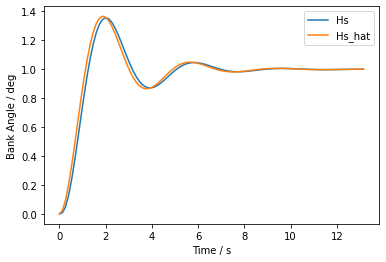

In [7]:
p.plot(t, s, label='Hs')
p.plot(t2,s2, label='Hs_hat')
p.xlabel('Time / s')
p.ylabel('Bank Angle / deg')
p.legend()
p.show()

The plot confirm the approximation preserves the significant dynamics of the original system, and the counterexample found by the SMT solving witness the requirement violation (i.e. within the given bound of K, it could have overshoot).

In [8]:
overshoot = new_checker.model(new_checker.factory.overshoot)
print(f"with K={K}, the system estimated to have overshoot of {overshoot}")

with K=0.27125775022143495, the system estimated to have overshoot of 0.3645531752454516
